In [36]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Times New Roman']
plt.rcParams['figure.dpi'] = 300
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pandas as pd
import re

In [191]:
# Model Opening
model_path = 'SIE+SHEAR'
model_ver = 'SIE_POS+FLUX_SHEAR'

if 'POS+FLUX' in model_ver:
    constraint = 'pos_flux'
elif 'POS' in model_ver:
    constraint = 'pos'

In [192]:
# Load the data
with open(model_path + '/' + model_ver + '_optresult' + '.dat', 'r') as file:
    opt_result = file.readlines()

opt_result

['------------------------------------------\n',
 'optimize ndim=12\n',
 'run 1: 380 lens models calculated\n',
 'chi^2 = 3.412909e+03  [N_data(extend): 0]\n',
 ' extend     : 0.000000e+00 0.000000e+00 0.000000e+00\n',
 ' point no 1 : 3.412909e+03 3.702283e+01 3.375886e+03 0.000000e+00 0.000000e+00\n',
 ' lens prior : 0.000000e+00\n',
 ' map prior  : 0.000000e+00\n',
 '\n',
 'omega = 0.3000  lambda = 0.7000  weos = -1.0000  hubble = 0.7000\n',
 '\n',
 'lens   sie     0.2613  1.278207e+02  2.081052e+01  2.074972e+01  2.320166e-01  2.509131e+00  0.000000e+00  0.000000e+00 \n',
 'lens   pert    0.2613  1.000000e+00  2.110309e+01  2.073726e+01  2.080415e-02  1.065928e+02  0.000000e+00  3.482196e-01 \n',
 'point  1.0000  2.091013e+01  2.075994e+01 \n',
 '------------------------------------------\n',
 '------------------------------------------\n',
 'optimize ndim=12\n',
 'run 2: 242 lens models calculated\n',
 'chi^2 = 3.368986e+03  [N_data(extend): 0]\n',
 ' extend     : 0.000000e+00 0.00

In [193]:
# Find the last line with 'optimize' in it
last_optimize_index = None
for idx in range(len(opt_result) - 1, -1, -1):
    if 'optimize' in opt_result[idx]:
        last_optimize_index = idx
        last_optimize_line = opt_result[idx]
        break
if last_optimize_index is None:
    raise ValueError("No line with 'optimize' found in the file.")

print(f"Last 'optimize' line found at index: {last_optimize_index}")

# Extract everything after the last 'optimize' line
opt_result = opt_result[last_optimize_index + 1:]

opt_result


Last 'optimize' line found at index: 46


['run 4: 37 lens models calculated\n',
 'chi^2 = 3.368559e+03  [N_data(extend): 0]\n',
 ' extend     : 0.000000e+00 0.000000e+00 0.000000e+00\n',
 ' point no 1 : 3.368559e+03 2.511238e+00 3.366048e+03 0.000000e+00 0.000000e+00\n',
 ' lens prior : 0.000000e+00\n',
 ' map prior  : 0.000000e+00\n',
 '\n',
 'omega = 0.3000  lambda = 0.7000  weos = -1.0000  hubble = 0.7000\n',
 '\n',
 'lens   sie     0.2613  1.273078e+02  2.081102e+01  2.074403e+01  2.920926e-01  3.564185e+00  0.000000e+00  0.000000e+00 \n',
 'lens   pert    0.2613  1.000000e+00  2.111219e+01  2.069566e+01  2.954578e-02  1.079066e+02  0.000000e+00  3.547413e-01 \n',
 'point  1.0000  2.091481e+01  2.074300e+01 \n',
 '------------------------------------------\n']

In [194]:
# Count the number of lines that start with 'lens'
lens_count = sum(1 for line in opt_result if line.startswith('lens'))
print(f"Number of 'lens' lines: {lens_count}")

# Initialize a dictionary to hold the lens parameters
lens_params_dict = {}

# Extract the lens parameters
lens_params = []
for line in opt_result:
    if line.startswith('lens'):
        # Extract the line and split it into parts
        parts = re.split(r'\s+', line.strip())
        print(parts)
        # Extract the lens name and parameters
        lens_name = parts[1]
        params = [float(x) for x in parts[2:]]

        # Store the parameters in the dictionary
        lens_params_dict[lens_name] = params
        lens_params.append((lens_name, params))

# Remove the first lens parameter
if lens_params:
    for i in range(len(lens_params)):
        lens_name, params = lens_params[i]
        lens_params_dict[lens_name] = params[1:]


# Number of len profiles
num_lens_profiles = len(lens_params_dict)
print(f"Number of lens profiles: {num_lens_profiles}")
        


    
lens_params_dict

Number of 'lens' lines: 2
['lens', 'sie', '0.2613', '1.273078e+02', '2.081102e+01', '2.074403e+01', '2.920926e-01', '3.564185e+00', '0.000000e+00', '0.000000e+00']
['lens', 'pert', '0.2613', '1.000000e+00', '2.111219e+01', '2.069566e+01', '2.954578e-02', '1.079066e+02', '0.000000e+00', '3.547413e-01']
Number of lens profiles: 2


{'sie': [127.3078, 20.81102, 20.74403, 0.2920926, 3.564185, 0.0, 0.0],
 'pert': [1.0, 21.11219, 20.69566, 0.02954578, 107.9066, 0.0, 0.3547413]}

In [195]:
# Define the lens corresponding parameters (order preserved)
# POW
pow_params = ['$z_{s,fid}$', 'x', 'y', 'e', '$θ_{e}$', '$r_{Ein}$', 'γ (PWI)']

# SIE
sie_params = ['σ', 'x', 'y', 'e', '$θ_{e}$', '$r_{core}$', 'NaN']

# NFW
nfw_params = ['M', 'x', 'y', 'e', '$θ_{e}$', 'c or $r_{s}$', 'NaN']

# EIN
ein_params = ['M', 'x', 'y', 'e', '$θ_{e}$', 'c or $r_{s}$', '$α_{e}$']

# SHEAR 
shear_params = ['$z_{s,fid}$', 'x', 'y', 'γ', '$θ_{γ}$', 'NaN', 'κ']

# Sersic
sersic_params = ['$M_{tot}$', 'x', 'y', 'e', '$θ_{e}$', '$r_{e}$', '$n$']

model_list = ['POW', 'SIE', 'NFW', 'EIN', 'PERT', 'SERS']
model_params = {
    'POW': pow_params,
    'SIE': sie_params,
    'NFW': nfw_params,
    'EIN': ein_params,
    'PERT': shear_params,
    'SERS': sersic_params
}


In [196]:
# Use generic column names: param1, param2, ...
df = pd.DataFrame()
rows = []
max_param_len = 0

for lens_name, params in lens_params_dict.items():
    row = {'Lens Name': lens_name}
    for i, val in enumerate(params):
        row[f'param{i+1}'] = val
    rows.append(row)
    if len(params) > max_param_len:
        max_param_len = len(params)

columns = ['Lens Name'] + [f'param{i+1}' for i in range(max_param_len)]
df = pd.DataFrame(rows, columns=columns)


In [197]:
df

,Lens Name,param1,param2,param3,param4,param5,param6,param7
0,sie,127.3078,20.81102,20.74403,0.292093,3.564185,0.0,0.000000
1,pert,1.0000,21.11219,20.69566,0.029546,107.906600,0.0,0.354741


In [198]:
with open(model_path + '/' + constraint + '_point' + '.py', 'r') as file:
    py = file.readlines()

py

['#!/usr/bin/env python\n',
 'import glafic\n',
 '\n',
 "glafic.init(0.3, 0.7, -1.0, 0.7, 'SIE+SHEAR/SIE_POS+FLUX_SHEAR', 20.0, 20.0, 21.56, 21.56, 0.01, 0.01, 1, verb = 0)\n",
 '\n',
 "glafic.set_secondary('chi2_splane 0', verb = 0)\n",
 "glafic.set_secondary('chi2_checknimg 0', verb = 0)\n",
 "glafic.set_secondary('chi2_restart   -1', verb = 0)\n",
 "glafic.set_secondary('chi2_usemag    1', verb = 0)\n",
 "glafic.set_secondary('hvary          0', verb = 0)\n",
 "glafic.set_secondary('ran_seed -122000', verb = 0)\n",
 '\n',
 'glafic.startup_setnum(2, 0, 1)\n',
 "glafic.set_lens(1, 'sie', 0.261343256161012, 1.30e+02, 20.81, 20.76, 0.109, 23.18, 0.0, 0.0)\n",
 "glafic.set_lens(2, 'pert', 0.261343256161012, 1.0, 20.89, 20.64, 0.1, 140.0, 0.0, 0.3)\n",
 'glafic.set_point(1, 1.0, 20.78, 20.78)\n',
 '\n',
 'glafic.setopt_lens(1, 0, 1, 1, 1, 1, 1, 0, 0)\n',
 'glafic.setopt_lens(2, 0, 0, 1, 1, 1, 1, 0, 1)\n',
 'glafic.setopt_point(1, 0, 1, 1)\n',
 '\n',
 '# model_init needs to be done again w

In [199]:
# Extracting the input parameters from the Python file

# Find all lines that start with 'glafic.set_lens('
set_lens_lines = [line for line in py if line.startswith('glafic.set_lens(')]
if not set_lens_lines:
    raise ValueError("No lines starting with 'glafic.set_lens(' found in the file.")
for l in set_lens_lines:
    print(f"Line found: {l.strip()}")

# Separate out everything in the parentheses
set_lens_params = []
for line in set_lens_lines:
    # Extract the part inside the parentheses
    match = re.search(r'set_lens\((.*?)\)', line)
    if match:
        params_str = match.group(1)
        # Split by commas and strip whitespace
        params = [param.strip() for param in params_str.split(',')]
        set_lens_params.append(params)
    else:
        raise ValueError(f"No valid parameters found in line: {line.strip()}")
print(f"Extracted parameters: {set_lens_params}")

# Store the parameters in a dictionary
set_lens_dict = {}
for params in set_lens_params:
    if len(params) < 3:
        raise ValueError(f"Not enough parameters found in line: {params}")
    lens_name = params[1].strip("'\"")  # Remove quotes from lens name
    lens_params = [float(x) for x in params[2:]]  # Skip index and lens name
    set_lens_dict[lens_name] = lens_params
print(f"Set lens parameters: {set_lens_dict}")

# Remove the first lens parameter
if set_lens_dict:
    for lens_name, params in set_lens_dict.items():
        set_lens_dict[lens_name] = params[1:]  # Remove the first parameter (index)
print(f"Set lens parameters after removing first parameter: {set_lens_dict}")



Line found: glafic.set_lens(1, 'sie', 0.261343256161012, 1.30e+02, 20.81, 20.76, 0.109, 23.18, 0.0, 0.0)
Line found: glafic.set_lens(2, 'pert', 0.261343256161012, 1.0, 20.89, 20.64, 0.1, 140.0, 0.0, 0.3)
Extracted parameters: [['1', "'sie'", '0.261343256161012', '1.30e+02', '20.81', '20.76', '0.109', '23.18', '0.0', '0.0'], ['2', "'pert'", '0.261343256161012', '1.0', '20.89', '20.64', '0.1', '140.0', '0.0', '0.3']]
Set lens parameters: {'sie': [0.261343256161012, 130.0, 20.81, 20.76, 0.109, 23.18, 0.0, 0.0], 'pert': [0.261343256161012, 1.0, 20.89, 20.64, 0.1, 140.0, 0.0, 0.3]}
Set lens parameters after removing first parameter: {'sie': [130.0, 20.81, 20.76, 0.109, 23.18, 0.0, 0.0], 'pert': [1.0, 20.89, 20.64, 0.1, 140.0, 0.0, 0.3]}


In [200]:
# Use generic column names: param1, param2, ...
df_input = pd.DataFrame()
rows_input = []
max_param_len_input = 0
for lens_name, params in set_lens_dict.items():
    row = {'Lens Name': lens_name}
    for i, val in enumerate(params):
        row[f'param{i+1}'] = val
    rows_input.append(row)
    if len(params) > max_param_len_input:
        max_param_len_input = len(params)
columns_input = ['Lens Name'] + [f'param{i+1}' for i in range(max_param_len_input)]
df_input = pd.DataFrame(rows_input, columns=columns_input)
df_input


,Lens Name,param1,param2,param3,param4,param5,param6,param7
0,sie,130.0,20.81,20.76,0.109,23.18,0.0,0.0
1,pert,1.0,20.89,20.64,0.100,140.00,0.0,0.3


In [201]:
# Extract input flags from the Python file

# Find all lines that start with 'glafic.set_flag('
set_flag_lines = [line for line in py if line.startswith('glafic.setopt_lens(')]
if not set_flag_lines:
    raise ValueError("No lines starting with 'glafic.setopt_lens(' found in the file.")
for l in set_flag_lines:
    print(f"Line found: {l.strip()}")

# Separate out everything in the parentheses
set_flag_params = []
for line in set_flag_lines:
    # Extract the part inside the parentheses
    match = re.search(r'setopt_lens\((.*?)\)', line)
    if match:
        params_str = match.group(1)
        # Split by commas and strip whitespace
        params = [param.strip() for param in params_str.split(',')]
        set_flag_params.append(params)
    else:
        raise ValueError(f"No valid parameters found in line: {line.strip()}")
print(f"Extracted parameters: {set_flag_params}")

# Store the parameters in a dictionary
set_flag_dict = {}
for params in set_flag_params:
    if len(params) < 2:
        raise ValueError(f"Not enough parameters found in line: {params}")
    # The lens name is not present in setopt_lens, so use the lens index to map to set_lens_dict
    lens_index = params[0].strip("'\"")
    # Find the lens name corresponding to this index from set_lens_params
    lens_name = None
    for lens_params in set_lens_params:
        if lens_params[0].strip("'\"") == lens_index:
            lens_name = lens_params[1].strip("'\"")
            break
    if lens_name is None:
        raise ValueError(f"Lens name for index {lens_index} not found in set_lens_params")
    flag = ','.join(params[1:])  # Join all flag values as a string
    set_flag_dict[lens_name] = flag
print(f"Set flag parameters: {set_flag_dict}")

# Remove the first flag parameter
if set_flag_dict:
    for lens_name, flag in set_flag_dict.items():
        flag_parts = flag.split(',')
        set_flag_dict[lens_name] = ','.join(flag_parts[1:])  # Remove the first flag parameter
        print(f"Set flag parameters after removing first parameter for {lens_name}: {set_flag_dict[lens_name]}")

# Dynamically create columns: 'Lens Name', 'flag1', 'flag2', ..., based on the maximum number of flags
df_flag = pd.DataFrame()
rows_flag = []
max_flag_len = 0

# First, determine the maximum number of flags
for flag in set_flag_dict.values():
    flag_parts = flag.split(',')
    if len(flag_parts) > max_flag_len:
        max_flag_len = len(flag_parts)

for lens_name, flag in set_flag_dict.items():
    flag_parts = flag.split(',')
    row = {'Lens Name': lens_name}
    for i, val in enumerate(flag_parts):
        row[f'flag{i+1}'] = val
    rows_flag.append(row)

columns_flag = ['Lens Name'] + [f'flag{i+1}' for i in range(max_flag_len)]
df_flag = pd.DataFrame(rows_flag, columns=columns_flag)
df_flag




Line found: glafic.setopt_lens(1, 0, 1, 1, 1, 1, 1, 0, 0)
Line found: glafic.setopt_lens(2, 0, 0, 1, 1, 1, 1, 0, 1)
Extracted parameters: [['1', '0', '1', '1', '1', '1', '1', '0', '0'], ['2', '0', '0', '1', '1', '1', '1', '0', '1']]
Set flag parameters: {'sie': '0,1,1,1,1,1,0,0', 'pert': '0,0,1,1,1,1,0,1'}
Set flag parameters after removing first parameter for sie: 1,1,1,1,1,0,0
Set flag parameters after removing first parameter for pert: 0,1,1,1,1,0,1


,Lens Name,flag1,flag2,flag3,flag4,flag5,flag6,flag7
0,sie,1,1,1,1,1,0,0
1,pert,0,1,1,1,1,0,1


In [202]:
dfs = []
for i in range(num_lens_profiles):
    lens_name = df['Lens Name'][i]
    # Find the model type (case-insensitive match)
    model_type = None
    for m in model_list:
        if m.lower() == lens_name.lower():
            model_type = m
            break
    if model_type is None:
        continue

    symbols = model_params[model_type][:7]
    # Row 2: input
    row_input = pd.DataFrame([df_input.iloc[i, 1:8].values], columns=symbols)
    # Row 3: output
    row_output = pd.DataFrame([df.iloc[i, 1:8].values], columns=symbols)
    # Row 4: flags
    row_flags = pd.DataFrame([df_flag.iloc[i, 1:8].values], columns=symbols)

    # Stack vertically, add a label column for row type
    lens_df = pd.concat([
        row_input.assign(Type='Input'),
        row_output.assign(Type='Output'),
        row_flags.assign(Type='Flag')
    ], ignore_index=True)
    lens_df.insert(0, 'Lens Name', lens_name)
    # Move 'Type' to the second column
    cols = lens_df.columns.tolist()
    cols.insert(1, cols.pop(cols.index('Type')))
    lens_df = lens_df[cols]
    dfs.append(lens_df)

# Example: show for the first lens
dfs[0]


,Lens Name,Type,σ,x,y,e,$θ_{e}$,$r_{core}$,NaN
0,sie,Input,130.0,20.81,20.76,0.109,23.18,0.0,0.0
1,sie,Output,127.3078,20.81102,20.74403,0.292093,3.564185,0.0,0.0
2,sie,Flag,1,1,1,1,1,0,0


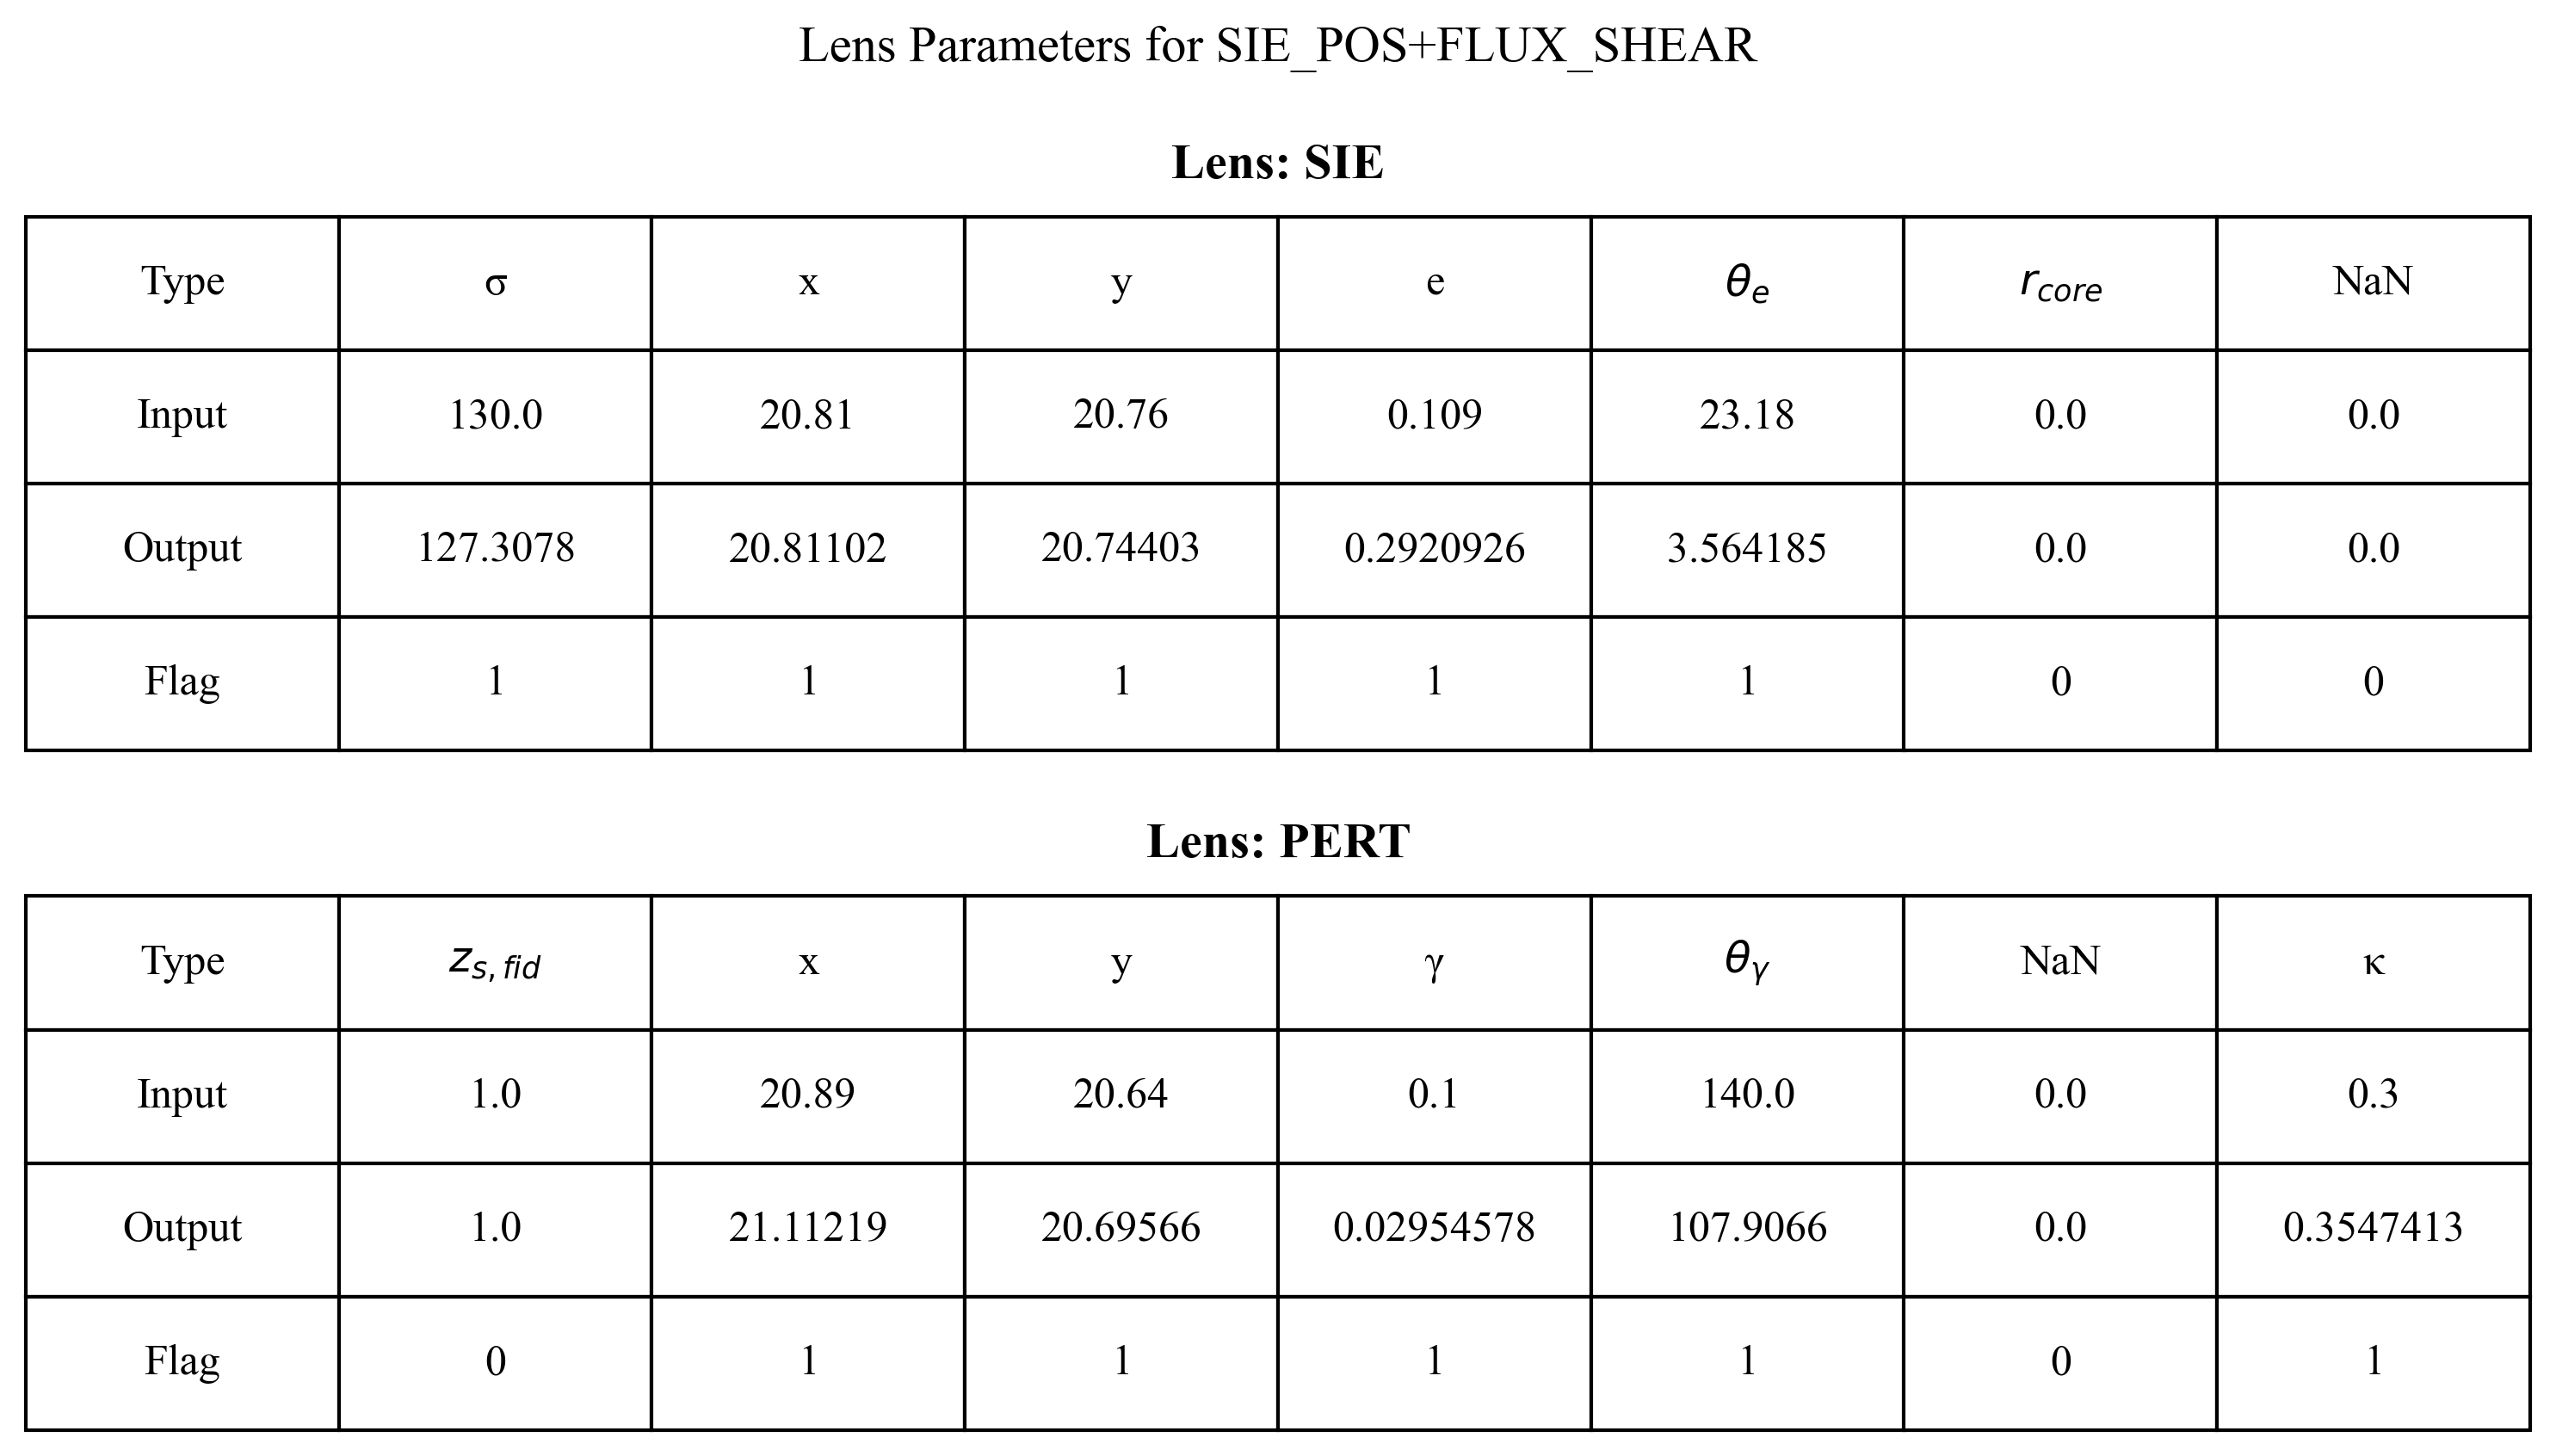

In [203]:
# Plot all lens parameter tables on the same figure, spaced vertically, without the first column (Lens Name)
fig, ax = plt.subplots(figsize=(10, 3 * len(dfs)))
ax.axis('off')

y_offset = 0.95  # Start at top
table_height = 0.55  # Height for each table
spacing = 0.15  # Space between tables
label_padding = 0.03  # Extra padding between label and table

for i, lens_df in enumerate(dfs):
    nrows = lens_df.shape[0]
    # Exclude the first column (Lens Name)
    table_data = lens_df.iloc[:, 1:].values
    col_labels = lens_df.columns[1:]
    # Calculate position for this table
    y_pos = y_offset - i * (table_height + spacing)
    table = ax.table(
        cellText=table_data,
        colLabels=col_labels,
        cellLoc='center',
        loc='center',
        bbox=[0, y_pos - table_height, 1, table_height]
    )
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.8,1.8)
    # Add lens name as a label above each table, all uppercase, with extra padding
    lens_label = f"   Lens: {lens_df['Lens Name'][0].upper()}   "
    ax.text(0.5, y_pos + label_padding, lens_label, ha='center', va='bottom', fontsize=14, fontweight='bold')

plt.title(f"Lens Parameters for {model_ver}", fontsize=14, pad=30)
plt.tight_layout()